# 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import learning_curve, GridSearchCV

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import matplotlib.pyplot as plt

import joblib

# 2. Display settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="default")

# 3. Getting the data

In [ ]:
train_df = pd.read_csv("Data/train.csv")

In [ ]:
val_df = pd.read_csv("Data/val.csv")

In [ ]:
test_df = pd.read_csv("Data/test.csv")

In [7]:
train_df.shape, val_df.shape, test_df.shape

((6695, 10), (1674, 10), (2093, 10))

In [8]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


## 3.1 Splitting the data

In [9]:
def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X, y)

In [10]:
X_train, y_train = split_data(train_df)

In [11]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included
...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info


In [12]:
y_train

0        7832
1        6540
2        7305
3        8366
4       11087
        ...  
6690    11093
6691     8891
6692    10262
6693     6152
6694    14594
Name: price, Length: 6695, dtype: int64

In [13]:
X_val, y_val = split_data(val_df)

In [14]:
X_test, y_test = split_data(test_df)

## 3.2 Meta-info

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6695 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 470.9+ KB


# 4. Data preprocessing

In [16]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]

num_cols = ["duration", "total_stops"]

cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [17]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [18]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
    ("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
    ("scaler", StandardScaler())
])

In [19]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("time", time_transformer, ["dep_time", "arrival_time"])
])

In [20]:
preprocessor.fit_transform(X_train)

array([[-3.67600796e-02,  3.00930116e-01,  0.00000000e+00, ...,
         1.62980523e+00,  8.24324352e-01, -9.03952976e-01],
       [ 4.27677252e-02,  3.00930116e-01,  0.00000000e+00, ...,
         3.00523012e-01, -1.36297644e+00,  1.03633329e-03],
       [-9.11565931e-01, -1.21504214e+00,  0.00000000e+00, ...,
         8.32235901e-01,  9.52240883e-02,  6.04362540e-01],
       ...,
       [-6.63041542e-01,  3.00930116e-01,  0.00000000e+00, ...,
        -1.29461565e+00,  8.24324352e-01, -1.50727918e+00],
       [-6.03395688e-01,  3.00930116e-01,  1.00000000e+00, ...,
         1.62980523e+00, -5.05959645e-02,  1.03633329e-03],
       [ 1.25556675e+00,  3.00930116e-01,  0.00000000e+00, ...,
         1.36394879e+00, -7.79696229e-01,  1.81101495e+00]])

# 5. Model selection

In [21]:
algorithms = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine":SVR(),
    "Random forest":RandomForestRegressor(n_estimators=10),
    "XGB":XGBRegressor(n_estimators=10)
}

In [22]:
data = pd.concat([train_df, val_df], axis=0)
data

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
1669,Spicejet,2019-05-01,Chennai,Kolkata,09:45:00,12:00:00,135,0.0,No Info,3597
1670,Indigo,2019-05-01,Kolkata,Banglore,08:10:00,13:00:00,290,1.0,No Info,5069
1671,Jet Airways,2019-05-27,Delhi,Cochin,05:30:00,12:35:00,425,2.0,In-flight meal not included,15544
1672,Jet Airways,2019-06-12,Mumbai,Hyderabad,19:35:00,21:05:00,90,0.0,In-flight meal not included,3210


In [23]:
X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(8369, 9) (8369,)


In [24]:
X_data.isnull().sum(), y_data.isnull().sum()

(airline            0
 date_of_journey    0
 source             0
 destination        0
 dep_time           0
 arrival_time       0
 duration           0
 total_stops        1
 additional_info    0
 dtype: int64,
 np.int64(0))

In [25]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )

    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores,
        y2=mean_scores + std_scores,
        alpha=0.5
    )

In [26]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1
    )

    # Print train and test scores for debugging
    mean_train_scores = np.mean(train_scores, axis=1)
    print("Mean train scores:", mean_train_scores)
    
    std_train_scores = np.std(train_scores, axis=1)
    print("Std train scores:", std_train_scores)
    
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis=1)
    print("Mean test scores:", mean_test_scores)
    
    std_test_scores = np.std(test_scores, axis=1)
    print("Std test scores:", std_test_scores)
    
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)

    # Plot training curve
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )

    # Plot test curve
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)
    ax.legend(loc="lower right")
    plt.show()

Mean train scores: [0.68134818 0.67236353 0.66585445 0.68363367 0.68741121]
Std train scores: [0.00964315 0.00082129 0.01507331 0.01551435 0.01400739]
Mean test scores: [ 6.29521888e-01 -2.60116877e+18 -3.25450823e+18 -1.58842512e+21
 -2.83677939e+19]
Std test scores: [1.41882115e-02 3.67860815e+18 4.60256968e+18 2.21207018e+21
 3.98777804e+19]


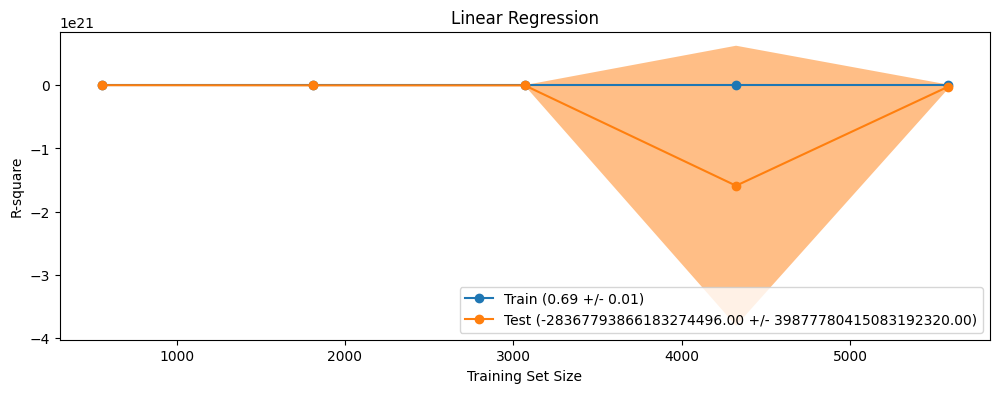

Mean train scores: [-0.03630392 -0.01031184 -0.001458    0.01061975  0.01991212]
Std train scores: [0.01479103 0.00035079 0.00221306 0.00225207 0.00143191]
Mean test scores: [-0.03184521 -0.00941464 -0.00258229  0.0081051   0.01964061]
Std test scores: [0.00783668 0.00219347 0.00345078 0.00409711 0.00361835]


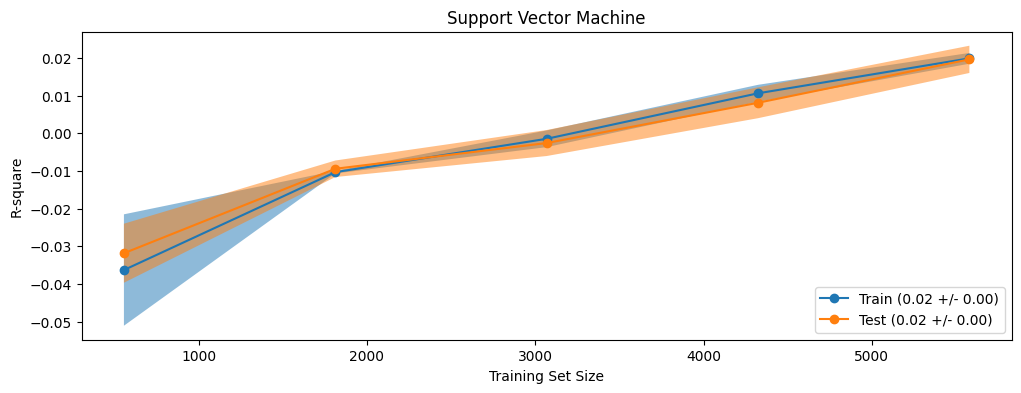

Mean train scores: [0.95248221 0.96661018 0.96599421 0.97157933 0.97139413]
Std train scores: [0.00520116 0.00524509 0.00645068 0.00350453 0.00424839]
Mean test scores: [0.69844753 0.79371098 0.80769553 0.83800624 0.85554237]
Std test scores: [0.02975923 0.01357159 0.01792584 0.00094944 0.02017863]


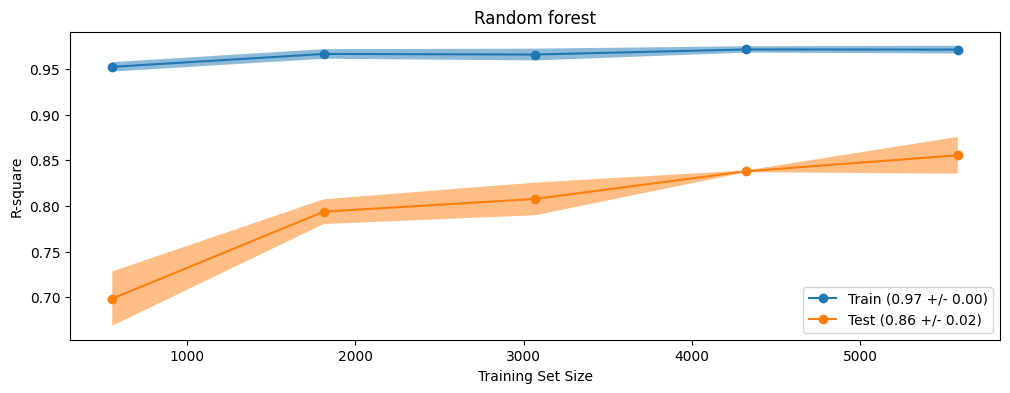

Mean train scores: [0.95411797 0.92374223 0.90353664 0.89802639 0.88939599]
Std train scores: [0.00199172 0.00515085 0.00059176 0.00332584 0.00720304]
Mean test scores: [0.70995398 0.77584543 0.79738969 0.81074347 0.811653  ]
Std test scores: [0.02589506 0.01423407 0.00634158 0.00941964 0.01009679]


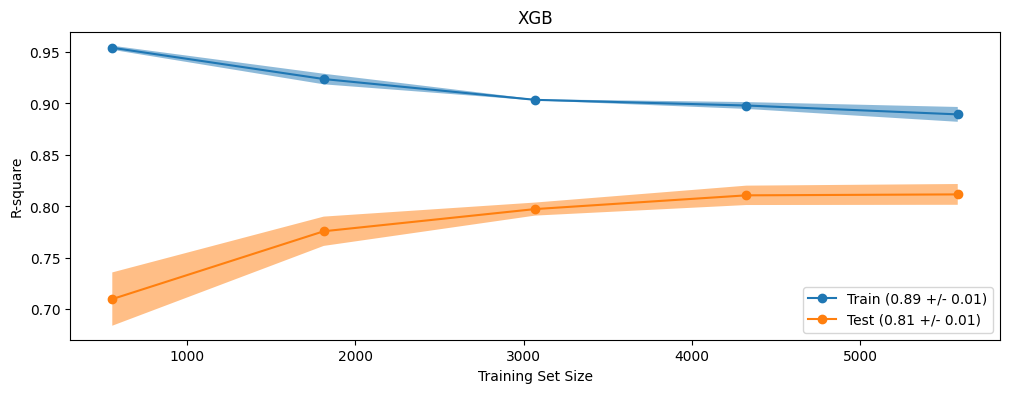

In [27]:
for name, alg in algorithms.items():
    plot_learning_curves(name, alg)

# 6. Model training

In [28]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("RF", RandomForestRegressor(n_estimators=200))
])

In [29]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('RF', RandomForestRegressor(n_estimators=200))])

# 7. Model evaluation

In [30]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [31]:
print(f"R2 Score on the Training data is {evaluate_model(X_data, y_data)}")

R2 Score on the Training data is 0.9811968826178589


In [32]:
print(f"R2 Score on the Test data is {evaluate_model(X_test, y_test)}")

R2 Score on the Test data is 0.8627794530129952


# 8. Model persistence

In [33]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [34]:
saved_model=joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('RF', RandomForestRegressor(n_estimators=200))])

In [35]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.8627794530129952

# 9. Hyperparameter tuning

In [36]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [37]:
grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid,
    scoring='r2',
    cv=3,
    verbose=3,
    n_jobs=-1
)

In [38]:
reg = Pipeline(steps=[
    ("pre", preprocessor),
    ("Grid search", grid_search)
])

In [39]:
reg.fit(X_data, y_data)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\khush\anaconda3\envs\env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('Grid search',
                 GridSearchCV(cv=3, estimator=RandomForestRegressor(),
                              n_jobs=-1,
                              param_grid={'max_depth': [10, 20, None],
                                          'max_features': ['sqrt', 'log2',
                                                           None],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [50, 100, 200]},
                              scoring='r2', verbose=3))])

In [40]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation R² Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation R² Score: 0.8701113816614713


## 9.2 Evaluating the model

In [41]:
y_pred = reg.predict(X_test)

In [42]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [43]:
print("Test R² Score:", r2)
print("Mean Squared Error on Test Set:", mse)

Test R² Score: 0.869793413739313
Mean Squared Error on Test Set: 2628964.895325641


## 9.3 Saving the model

In [44]:
joblib.dump(reg, "optimized_rf_pipeline.joblib")

['optimized_rf_pipeline.joblib']